In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from typing import List
from sklearn import datasets
from functools import partial
import time
import math

# 逻辑回归

## 感知机中对于噪音的处理

[感知机](./perceptron.ipynb)认为决策边界是类别的分界线，在法向量$\boldsymbol{w}$指向的一侧是正类，在$\boldsymbol{w}$指向一侧的另一侧是负类，因此感知机的认为的上帝函数为

$$h(\boldsymbol{x})=\boldsymbol{w}\boldsymbol{x}+b$$

对于分错的点，感知机认为是数据噪音(可以理解为不符合上帝函数$f$的数据)，对与这种噪音数据，感知机无法处理。

## 线性回归中对于噪音的处理

在[线性回归](./linear_regression.ipynb)中，我们证明了当噪音$\epsilon$和数据集$D$服从正态分布时，经验误差函数就是

$$\hat{R}_D(h)=\sum_{i}(y_i-\boldsymbol{w}^\mathrm{T})^2$$

因此线性回归在获取经验误差时就已经考虑到噪音了。

## 分类中的噪音
对于数据集$D$中的某个特征$\boldsymbol{x}$，对其分类也是具有随机性的，但是[感知机](./perceptron.ipynb)中认为$y$的值是由上帝函数$y=f(x)$决定的，没有随机性，因此感知机无法正确处理噪音。

逻辑回归和线性回归一样，会将$y$这种随机性也就是噪音考虑进去，下面我们看下逻辑回归是如何处理的。

## 逻辑回归中对于噪音的处理

### Sigmoid函数

$$S(z)=\frac{1}{1+e^{-z}},\quad z\in\mathbb{R}$$

Sigmoid函数值域为$(0, 1)$, 其函数图像为

![](../resources/sigmoid.svg)

### 分布
在[线性回归](./linear_regression.ipynb)我们描述了$Y$服从$X$的条件分布

$$Y \sim P(Y|X) $$

在逻辑回归也是类似，由于是二分类问题，$P(Y|X)$还是二项分布

$$P(Y|X)=
\begin{cases}
    S(\boldsymbol{w}^\mathrm{T}\boldsymbol{x}),&y=+1\\
    1-S(\boldsymbol{w}^\mathrm{T}\boldsymbol{x}),&y=-1
\end{cases}$$

### 经验误差

逻辑回归中的经验误差

$$\hat{R}_D(h)=\frac{1}{|D|}\sum_{i}e(h, \boldsymbol{x_i})=\frac{1}{|D|}\sum_{i}\ln\left(1+e^{-y_i\boldsymbol{w}^\mathrm{T}\boldsymbol{x_i}}\right)$$

具体推导可以参考[线性回归](./linear_regression.ipynb)中使用最大似然思想的推导过程。

那么逻辑回归就是优化经验误差最小，也就是求出

$$\hat{\boldsymbol{w}}=\operatorname*{argmin}_{\boldsymbol{w}}\hat{R}_D(h)$$

## 梯度下降法(Gradient descent)
梯度是函数值增长最快的方向，梯度的反方向是函数值下降最快的方向，那么我们只要求出$\hat{R}_D(h)$的梯度，并且沿着梯度下降的方向更新$\boldsymbol{w}$，直到$\hat{R}_D(h)$低于某个阈值就可以学习完毕，得到模型参数$\boldsymbol{w}$了。

具体步骤为：
1. 选择初始点$\boldsymbol{w}_0$、学习率$\eta$、迭代上线$epoch$以及梯度模长上限$\epsilon$
2. 计算$\nabla f(\boldsymbol{w_0})$，如果$||\nabla f(\boldsymbol{w_0})|| < \epsilon$或者到达迭代上限epoch，终止训练
3. 通过$\boldsymbol{w}_{k+1}=\boldsymbol{w}_k-\eta\nabla f(\boldsymbol{x}_k)$，更新参数$w$，回到2

In [3]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

def h(x, wk):
    ones = np.ones(x.shape[0]).reshape(-1, 1)
    x = np.hstack((ones, x))
    return sigmoid(x@wk)

def drhd(wk: np.ndarray, X: np.ndarray, y: np.ndarray) -> np.ndarray:
    """wk: (X.shape[0],)
    y: (X.shape[0],)
    """
    ewk = []
    n = X.shape[1]
    for i in range(n):
        ew = np.mean(-y*X[:, i] * np.exp(-y * (X @ wk)) / (1 + np.exp(-y * (X @ wk))))
        ewk.append(ew)
    return np.array(ewk)

def logistic_regression_train(X: np.ndarray, y: np.ndarray, epoch: int, 
                              learning_rate: float, epsilon: float, **kwargs) -> (np.ndarray):
    gradient = 0
    ones = np.ones(X.shape[0]).reshape(-1, 1)
    X = np.hstack((ones, X))
    wk = np.zeros(X.shape[1], dtype=np.float128)
    op = kwargs.pop("op") if "op" in kwargs else None
    for i in range(epoch):
        if op:
            op(i, X, y, wk)
        gradient = drhd(wk, X, y)
        if np.linalg.norm(gradient) < epsilon:
            break
        wk = wk - learning_rate * gradient
    if op:
        op(i, X, y, wk)
    return wk

接下来使用[感知机](./perceptron.ipynb)中用到的信用卡发放的数据集，对该数据集进行逻辑回归，通过下面图像可以看到，类别为正类的点和负类的点都距离决策边界非常远，也就是表示概率越大，并且决策边界上的概率为0.5。

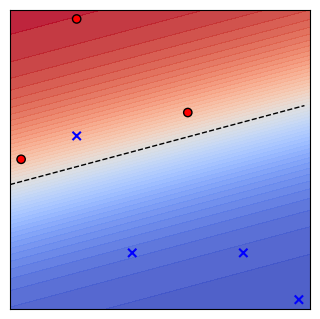

In [4]:
# 信用卡发放的数据集
X = np.array([[5,2], [3,2], [2,7], [1,4], [6,1], [4,5], [2,4.5]])
y = np.array([-1, -1, 1, 1, -1, 1, -1])

learning_rate = 0.1
epoch = 5000
epsilon = 0.01
# 逻辑回归
wk = logistic_regression_train(X, y, epoch, learning_rate, epsilon)

plt.rcParams.update({'font.size': 14})
# 设置subfigure
fig, ax = plt.subplots(figsize = (6, 3))
fig.subplots_adjust(left=0.25, right=0.75, top=0.999, bottom=0.001)
ax.set(xticks=[], yticks=[])
x1_min, x1_max = X[:, 0].min() - 0.2, X[:, 0].max() + 0.2
x2_min, x2_max = X[:, 1].min() - 0.2, X[:, 1].max() + 0.2
ax.set_xlim(x1_min, x1_max),ax.set_ylim(x2_min, x2_max)
# 绘制决策区域
resolution = 0.03
xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution), np.arange(x2_min, x2_max, resolution))
xx = np.c_[xx1.ravel(), xx2.ravel()]
Z = h(xx, wk).reshape(xx1.shape)
ax.contourf(xx1, xx2, Z, 50, cmap="coolwarm", vmin=0, vmax=1, alpha=0.9)
# 绘制数据集
markers = ('x', 'o')
vmin, vmax = min(y), max(y)
cm = ListedColormap(('blue', 'red'))
for cl, m in zip(np.unique(y), markers):
	edgecolors = 'k'
	if m == 'x':
		edgecolors = None
	ax.scatter(x=X[y==cl, 0], y=X[y==cl, 1], c=y[y==cl], alpha=1, vmin = vmin, 
			vmax = vmax, cmap=cm, edgecolors=edgecolors, marker = m)
# 绘制决策边界
def lh(x):
	return -wk[0]/wk[2]-wk[1]/wk[2]*x
xx1 = np.arange(x1_min, x1_max, 0.1)
ax.plot(xx1, lh(xx1), 'k--', lw=1)
plt.show()

学习率$\eta$是梯度下降法引入的一个额外的参数，这个参数和收敛速度息息相关。当$\eta$过小时，$\boldsymbol{w}$每次迭代的步长比较小，因此需要更多次迭代才能收敛，而$\eta$过大，$\boldsymbol{w}$更新可能会错过最小点，并且来回震荡，导致无法收敛。

下面以安德森鸢尾花卉数据集为例，使用不同的$\eta$观察$\hat{R}_D{h}$的变化。可以看到当$\eta$等于0.2时，要迭代43767次才能收敛，而当$\eta$过大时，$\hat{R}_D(h)$一直震荡直到epoch结束也无法收敛。

learning rate=0.2, iteration=43767,elapsed ms=8177.659404, rdh=0.11
learning rate=2, iteration=1707,elapsed ms=319.624175, rdh=0.11
learning rate=20, iteration=50001,elapsed ms=9208.010547, rdh=0.49


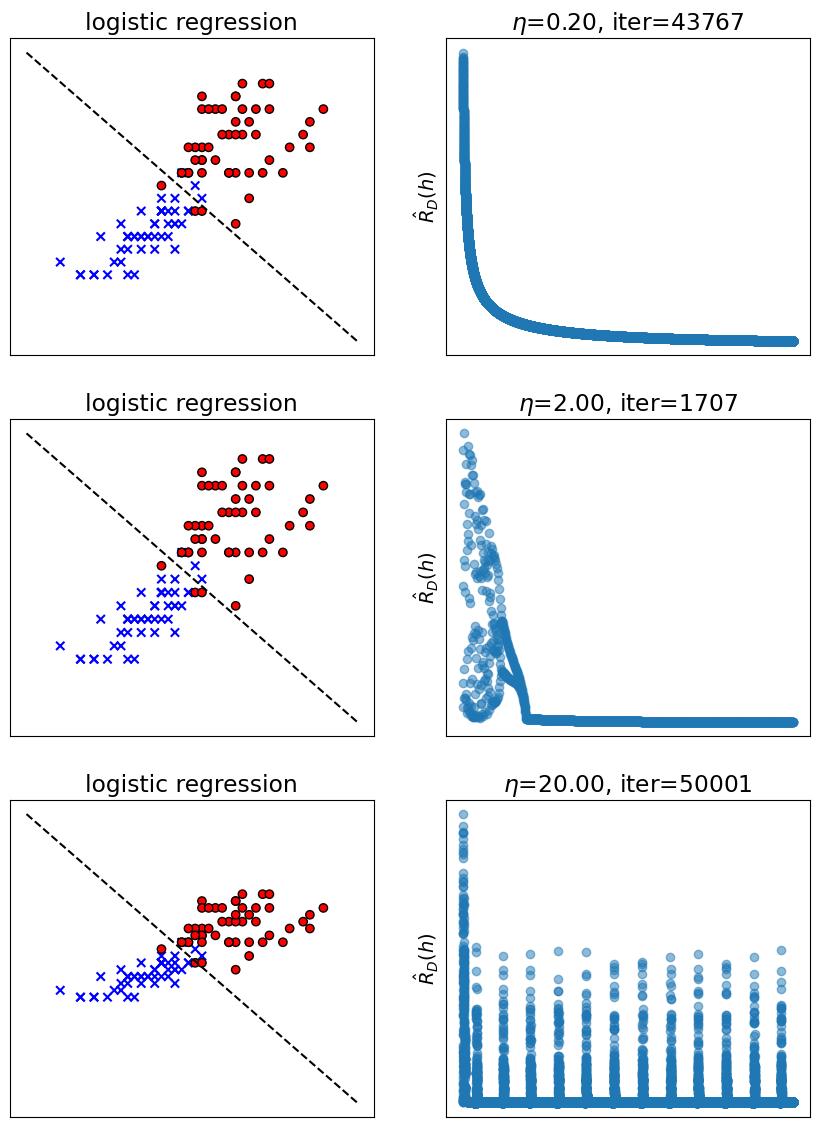

In [5]:
def rdh(X: np.ndarray, y: np.ndarray, wk: np.ndarray) -> float:
    return np.mean(np.log(1 + np.exp(-y * (X @ wk))))

def record_rdh(rdh_list: List[float], i: int, X: np.ndarray, y: np.ndarray, wk: np.ndarray):
    rdh_list.append(rdh(X, y, wk))

fig, axes = plt.subplots(figsize=(16, 12), nrows=3, ncols=2)
fig.subplots_adjust(left=0.25, right=0.75, top=0.999, bottom=0.1)
epoch = 50000
epsilon = 0.001
learning_rate_list = (0.2, 2, 20)
iris = datasets.load_iris()
sampleNumber = 100
X: np.ndarray = iris.data[50:50+sampleNumber, [2,3]]
y = np.where(iris.target[50:50+sampleNumber] == 1, -1, 1)
i_list = (0, 1, 2)
markers = ('x', 'o')
cm = ListedColormap(('blue', 'red'))
xmin, xmax = X[:, 0].min(), X[:, 0].max()
ymin, ymax = X[:, 1].min(), X[:, 1].max()

for learning_rate, i in zip(learning_rate_list, i_list):
    ax0, ax1 = axes[i][0], axes[i][1]
    ax0.set(xticks=[], yticks=[])
    ax1.set(xticks=[], yticks=[])
    ax0.set_title("logistic regression")
    vmin, vmax = min(y), max(y)
    for cl, m in zip(np.unique(y), markers):
        edgecolors = 'k'
        if m == 'x':
            edgecolors = None
        ax0.scatter(x=X[y==cl, 0], y=X[y==cl, 1], c=y[y==cl], alpha=1, 
                   vmin = vmin, vmax = vmax, cmap=cm, edgecolors=edgecolors, marker = m)
    rdh_list = []
    op = partial(record_rdh, rdh_list)
    start = time.monotonic_ns()
    wk = logistic_regression_train(X, y, epoch, learning_rate, epsilon, op=op)
    print(f"learning rate={learning_rate}, iteration={len(rdh_list)}," 
          f"elapsed ms={(time.monotonic_ns() - start)/1e6}, rdh={rdh_list[-1]:.2f}")
    xx = np.linspace(xmin-0.5, xmax+0.5)
    yy = (-wk[0]-wk[1]*xx)/wk[2]
    ax0.plot(xx, yy, 'k--')

    ax1.set_ylabel("$\hat{R}_D(h)$")
    ax1.set_title(r"$\eta$={:.2f}, iter={}".format(learning_rate, len(rdh_list)))
    xx = np.arange(len(rdh_list))
    ax1.scatter(x=xx, y=rdh_list, alpha=0.5)

## 随机梯度下降法(Stochastic gradient descent)
梯度下降法每次迭代都需要遍历整个数据集$D$计算梯度，这在数据集$D$太大或者迭代次数太多时，效率不佳。比如当$eta=0.2 , \ \epsilon=0.001$时，需要迭代43767次耗时8s才能终止。

随机梯度下降法(Stochastic gradient descent)是为了提高梯度下降法的效率提出来的，其步骤为

1. 选择初始参数$\boldsymbol{w}$、学习率$\eta$以及迭代上线epoch
2. 从数据集$D$中随机选取第$i$个点构造新的数据集$D_i$，在$D_i$上计算$\nabla \hat{R}_{D_i}(h, \boldsymbol{w})$，如果到达迭代上限，训练终止
3. 更新$\boldsymbol{w}=\boldsymbol{w}-\eta \nabla \hat{R}_{D_i}(h, \boldsymbol{w})$，回到2

随机梯度下降法由于每次是在数据集$D$中一个特征上计算梯度的，在快要抵达最小值时可能会发生震荡，在工程上，可以通过每迭代$k$次在数据集$D$上计算一次完整的$||\nabla\hat{R}_D(h)||$，并且将参数$\boldsymbol{w}$记录下来，迭代结束后，返回$||\nabla\hat{R}_D(h)||$最小的对应的$\boldsymbol{w}$。

随机梯度法可行的原因是我们假设数据集$D$是独立同分布的采样，因此从$D$中随机抽取一个元素都是数据集$D$的独立同分布，因此有

$$E[\nabla\hat{R}_{D_i}(h)]=E[\nabla\hat{R}_D(h)]$$

也就是$\nabla\hat{R}_{D_i}(h)$是$\nabla\hat{R}_D(h)$的无偏估计。

In [7]:
def sgd_drhd(X: np.ndarray, y: np.ndarray, wk: np.ndarray) -> np.ndarray:
    idx = np.random.randint(X.shape[0])
    xi, yi = X[idx], y[idx]
    return -yi*xi*math.exp(-yi*np.dot(wk, xi))/(1+math.exp(-yi*np.dot(wk, xi)))

def SGD(X: np.ndarray, y: np.ndarray, learning_rate: float, epoch: int, **kwargs) -> np.ndarray:
    ones = np.ones(X.shape[0]).reshape(-1, 1)
    X = np.hstack((ones, X))
    wk = np.zeros(X.shape[1], dtype=np.float128)
    op = kwargs.pop("op") if "op" in kwargs else None
    for i in range(epoch):
        if op:
            op(i, X, y, wk)
        wk = wk - learning_rate*sgd_drhd(X, y, wk)
    if op:
        op(i, X, y, wk)
    return wk

learning rate=0.2, iteration=50001,elapsed ms=3083.163283, rdh=0.13
learning rate=2, iteration=50001,elapsed ms=3078.631555, rdh=2.42
learning rate=10, iteration=50001,elapsed ms=3026.577903, rdh=10.09


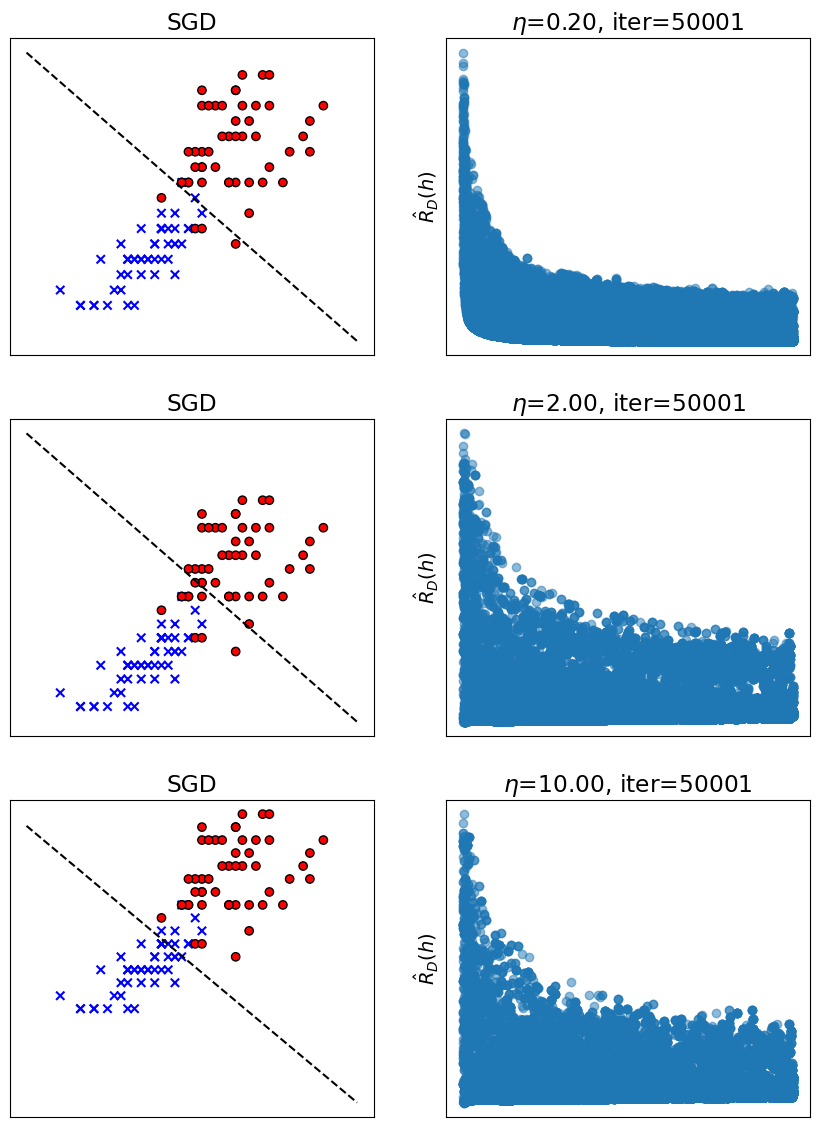

In [8]:
fig, axes = plt.subplots(figsize=(16, 12), nrows=3, ncols=2)
fig.subplots_adjust(left=0.25, right=0.75, top=0.999, bottom=0.1)
learning_rate_list = (0.2, 2, 10)

for learning_rate, i in zip(learning_rate_list, i_list):
    ax0, ax1 = axes[i][0], axes[i][1]
    ax0.set(xticks=[], yticks=[])
    ax1.set(xticks=[], yticks=[])
    ax0.set_title("SGD")
    vmin, vmax = min(y), max(y)
    for cl, m in zip(np.unique(y), markers):
        edgecolors = 'k'
        if m == 'x':
            edgecolors = None
        ax0.scatter(x=X[y==cl, 0], y=X[y==cl, 1], c=y[y==cl], alpha=1, 
                   vmin = vmin, vmax = vmax, cmap=cm, edgecolors=edgecolors, marker = m)
    rdh_list = []
    op = partial(record_rdh, rdh_list)
    start = time.monotonic_ns()
    wk = SGD(X, y, learning_rate, epoch, op=op)
    print(f"learning rate={learning_rate}, iteration={len(rdh_list)}," 
          f"elapsed ms={(time.monotonic_ns() - start)/1e6}, rdh={rdh_list[-1]:.2f}")
    xx = np.linspace(xmin-0.5, xmax+0.5)
    yy = (-wk[0]-wk[1]*xx)/wk[2]
    ax0.plot(xx, yy, 'k--')

    ax1.set_ylabel("$\hat{R}_D(h)$")
    ax1.set_title(r"$\eta$={:.2f}, iter={}".format(learning_rate, len(rdh_list)))
    xx = np.arange(len(rdh_list))
    ax1.scatter(x=xx, y=rdh_list, alpha=0.5)

## 非线性分类
逻辑回归也会遇到过欠拟合和过拟合的问题，在[之前](./theory.ipynb)我们分析过欠拟合和过拟合分别如何解决：

- 欠拟合：说明选择的模型不够复杂，可以使用更复杂的模型
- 过拟合：模型过于复杂，在测试集上泛化能力较差，需要降低模型的复杂度

和[线性回归](./linear_regression.ipynb)一样，可以通过使用非线性的假设空间来提高模型复杂度或者添加罚项降低模型的复杂度。

线性回归的假设空间为

$$\mathcal{H}=\{\ h(x)=S(\boldsymbol{w}^\mathrm{T}\boldsymbol{x})\ \}$$

现在以如何假设空间举例看下非线性的假设空间如何结合逻辑回归完成学习。

$$\mathcal{H}=\{\ h(x)=S(\boldsymbol{w}^\mathrm{T}\boldsymbol{x^2})\ \}$$

[ 9.93523179 -0.90851188 -0.79163437]


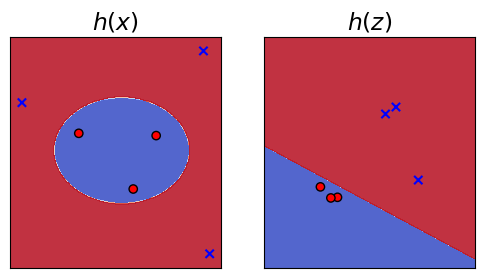

In [9]:
# 定义数据集
X = np.array([[-1.8, 0.6], [0.48, -1.36], [1.44, 0.52], [3.42, 3.5], [3.68, -3.64], [-4.18, 1.68]])
y = np.array([1, 1, 1, -1, -1, -1, ])
Z = X**2

# 超参数
epoch = 50000
learning_rate = 0.1
epsilon = 0.1

# 训练
w = SGD(Z, y, learning_rate, epoch=epoch, epsilon=epsilon)
print(w)

markers = ('x', 'o')
vmin, vmax = min(y), max(y)
cm = ListedColormap(('blue', 'red'))

def h2(x, w):
    ones = np.ones(x.shape[0]).reshape(-1, 1)
    x = np.hstack((ones, x))
    return sigmoid((x**2)@w)

fig, axes = plt.subplots(figsize=(6, 3), ncols=2, nrows=1)
titles = ("$h(x)$", "$h(z)$")
limits = (0.5, 10)

for xx, ax, title, hx, limit in zip((X, Z), axes, titles, (h2, h), limits):
    ax.set_title(title)
    ax.set(xticks=[], yticks=[])
    x1_min, x1_max = xx[:, 0].min()-limit, xx[:,0].max()+limit
    x2_min, x2_max = xx[:,1].min()-limit, xx[:,1].max()+limit
    resolution = 0.03
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution), np.arange(x2_min, x2_max, resolution))
    xxx = np.c_[xx1.ravel(), xx2.ravel()]
    Z = hx(xxx, wk).reshape(xx1.shape)
    ax.contourf(xx1, xx2, Z, 25,  cmap="coolwarm", vmin=0, vmax=1, alpha=0.9)
    for cl, m in zip(np.unique(y), markers):
        edgecolors = 'k'
        if m == 'x':
            edgecolors = None
        ttt = y == cl
        ax.scatter(x=xx[y==cl, 0], y=xx[y==cl, 1], c=y[y==cl], alpha=1, vmin = vmin, 
			    vmax = vmax, cmap=cm, edgecolors=edgecolors, marker = m)

## 多分类

### 一对多(one-vest-rest)
将数据集分成$A$类和非$A$类，那么就可以运用逻辑回归在数据集上学习，接下来依次对数据集中每个类别用同样的操作，将数据集分成该类别和非该类别两类并运用逻辑回归。

现在有多少类别就有多少个逻辑回归学习到的模型，预测时，将特征通过所有模型后得到一些列概率值，那么最大的概率所对应的类别就是最终的分类。

[感知机](./perceptron.ipynb)不能用于一对多，这是因为学习到的$n$个决策边界可能判定全是$-1$，就导致无法预测。

### 一对一(one-vs-one)
将数据集两两配对，并在新的数据集上运用逻辑回归，最终模型数量为

$${n \choose 2}$$

其中n为类别总数。

在预测时，在所有的模型上进行预测，并记录预测出的类别，最终会答案时类别出现次数最多的类别。